In [1]:
import sys
sys.path.append('..')

In [2]:
from importlib import reload
from os.path import exists

import networkx as nx
import numpy as np
import pandas as pd
import lib.obo
import lib.classification.elastic
import lib.classification.validation
import lib.utils
import data
import pymonad

reload(lib.classification.validation)
reload(lib.classification.elastic)
reload(lib.obo)
reload(lib.utils)
reload(data)

from lib.classification.elastic import annotate_index, collapse_matches, build_synonyms_graph, search_item
from lib.utils import map_series, expand_dataframe, expand, flatten
from lib.classification.validation import correct_ratio, incorrect_ratio, perfect_match
from geo_annotation.import_ontology_es import import_ontology
from elasticsearch import Elasticsearch
from lib.obo import read_ontology, Ontology
pd.set_option('display.width', 512)

In [47]:
import seaborn
%matplotlib inline

In [4]:
# Вытаскиваем все семплы 
import pymongo
db = pymongo.MongoClient().scraper_test_dev

In [5]:
file_sample2series = '../data/geo-annotation/sample2series.all.res1.pickle'
if not exists(file_sample2series):
    c = db.samples.find({
        }, {
            '_id':0,
            'accession': 1,
            'series': 1
        })
    sample2series = (
        pd.DataFrame.from_records(
            [
            (x['accession'], series) 
             for x in c 
             for series in x['series']],
            columns=['sample', 'series']
        )
        .drop_duplicates()
        .set_index('sample')

    )
    sample2series.to_pickle(file_sample2series)
else: 
    sample2series = pd.read_pickle(file_sample2series)

In [6]:
sample2series.shape

(2425973, 1)

In [7]:
es = Elasticsearch()
ontology = read_ontology('../data/geo-annotation/brenda-tissue-ontology.obo',
                         exclude_duplicates=True,
                         subgraph='BTO:0001489')

Read obo graph
Name: 
Type: DiGraph
Number of nodes: 5659
Number of edges: 6430
Average in degree:   1.1362
Average out degree:   1.1362


In [8]:
# Убираем синонимы состоящие только из коротких слов  (len <= 2 )
# (вообще ошибка происходит изза стоп-слов в Elasticsearch, но так проще)

def cell():
    import re
    def tokenize(s):
        return re.split(r'[^\w\d]+', s)
    
    def all_short(synonym):
        return all(len(t) <= 2 for t in tokenize(synonym))
    
    for item_id, item in ontology.meta.items():
        item.synonyms = [s for s in item.synonyms if not all_short(s)]

cell()

In [9]:
# import_ontology(ontology, 'tissue_ontology')
# syn_ontology = Ontology(build_synonyms_graph(ontology, es, 'tissue_ontology'), list(ontology.items()))

In [51]:
annotation_result_file = '../data/geo-annotation/samples.tissue.all.res6.pickle'
if not exists(annotation_result_file):
    res = annotate_index(client=es,
                         ontology=ontology,
                         index='samples',
                         fields=['title', 'characteristics_raw', 'source_name'],
                         id_field='accession'
                        )

    res.to_pickle(annotation_result_file)

else:
    res = pd.read_pickle(annotation_result_file)

In [52]:
# len(res), len(validation_set_ids) 976291
len(res)

1347796

In [56]:
res['classes'] = res['classes'].map(lambda xs: list(set(xs)))

In [57]:
res[:10]

,classes
item,
GSM1006272,[BTO:0000759]
E-MTAB-3099_162,[BTO:0000759]
GSM645939,[BTO:0000855]
GSM429771,[BTO:0000848]
E-MTAB-3732_3998,"[BTO:0000876, BTO:0000089]"
GSM1528749,[BTO:0000282]
GSM929743,"[BTO:0004850, BTO:0000140, BTO:0001441, BTO:00..."
GSM29232,"[BTO:0001239, BTO:0001583]"
GSM642303,"[BTO:0000782, BTO:0001372]"


In [58]:
(
    res[~(res.index.str.startswith('GSM'))]
    .head()
    .assign(class_=lambda d: d.classes.map(lambda x: x[0]))
    .assign(class_=lambda d: d.class_.map(ontology.name))
)

,classes,class_
item,,
E-MTAB-3099_162,[BTO:0000759],liver
E-MTAB-3732_3998,"[BTO:0000876, BTO:0000089]",monocyte
E-MTAB-764_17,[BTO:0000763],lung
E-MTAB-40_2624,"[BTO:0000776, BTO:0000775]",b-lymphocyte
E-TABM-661_2949,[BTO:0004359],paw


In [14]:
# import pymongo 
# db = pymongo.MongoClient().scraper_meta
# file_human_samples = '../data/geo-annotation/human-samples.res1.pickle'
    
# if not exists(file_human_samples):
#     human_samples = pd.DataFrame(dict(sample=[int(s['accession'][3:]) for s in db.samples.find({'organism': 'Homo sapiens'}, {'_id': 0, 'accession': 1})]))
#     human_samples.to_pickle(file_human_samples)
# else:
#     human_samples = pd.read_pickle(file_human_samples)

In [13]:
# human_samples.set_index('sample')[:5]

In [15]:
# res_human = pd.merge(res, human_samples.set_index('sample'), left_index=True, right_index=True, how='inner')
# res_human[:5]

In [16]:
# res.shape, res_human.shape

In [17]:
# Собираем семплы в серии
# sample2series.index = sample2series.index.map(lambda s: int(s[3:]))
# sample2series.head()

In [59]:
_t = pd.merge(res, sample2series, left_index=True, right_index=True, how='left')
_t[_t.series.isnull()]

,classes,series


In [ ]:
def flat_set(iterables):
    return {x for it in iterables for x in it}

res_series = (
    pd.merge(res, sample2series, left_index=True, right_index=True)
    .reset_index()
    .rename(columns=dict(index='annotated_samples'))
    .groupby('series')
    .agg(dict(classes=flat_set, annotated_samples=lambda x: len(set(x))))
#     [['']]
#     .apply(flat_set)
#     .to_frame()
)
res_series[:10]

In [20]:
# # Проверяем все ли семплы у серий аннотированы

# series_samples = (
#     pd.DataFrame(
#         list(db.series.find(
#                 {'accession': {'$in': res_series.index.unique().tolist()}},
#                 {'_id': 0, 'accession': 1, 'samples': 1}
#             ))
#     )
#     .rename(columns={'samples': 'stored_samples', 'accession': 'series'})
#     .assign(stored_samples= lambda d: d.stored_samples.map(len))
#     .set_index('series')
# )
# series_samples.head()

In [25]:
sample2series.head()

,series
sample,
GSM148280,GSE6448
GSM1690912,GSE69034
GSM1690913,GSE69035
GSM1690914,GSE69034
GSM148279,GSE6448


In [26]:
series_samples = (
    sample2series
    .reset_index()
    .rename(columns={'sample': 'stored_samples'})
#     .assign(sample= lambda d: d['stored_samples'].map('GSM{}'.format))
    .groupby('series')
    .stored_samples
    .apply(len)
    .to_frame()
)
series_samples.head()

,stored_samples
series,
E-AFMX-1,21
E-AFMX-10,6
E-AFMX-11,55
E-AFMX-12,49
E-AFMX-13,12


In [44]:
print(res_series.shape)
res_series_partial_annotated = (
    res_series
    .join(series_samples)
    .query('annotated_samples <= stored_samples')
    .assign(annotated_ratio=lambda d: d.annotated_samples.astype(float).combine(d.stored_samples, lambda a, s: a/s))
    .query('annotated_ratio > 0.7')
#     .annotated_samples
#     .sum()
#     .query('annotated_samples < stored_samples and stored_samples < 501')
#     .shape
)
print(res_series_partial_annotated.shape)
res_series_partial_annotated.head()

(4223, 2)
(3739, 4)


,annotated_samples,classes,stored_samples,annotated_ratio
series,,,,
E-AFMX-1,21,"set([BTO:0000484, BTO:0002807, BTO:0000142])",21,1
E-AFMX-10,6,"set([BTO:0001629, BTO:0000562])",6,1
E-AFMX-11,55,"set([BTO:0000759, BTO:0000671, BTO:0001363, BT...",55,1
E-AFMX-12,49,"set([BTO:0001422, BTO:0001424, BTO:0000416])",49,1
E-AFMX-13,12,"set([BTO:0001422, BTO:0001424, BTO:0000416])",12,1


In [31]:
def doid_id(item_id):
    return "BTO:{:07}".format(item_id)


def ontology_name(item_id):
    if item_id not in ontology.meta:
        return item_id
    return ontology.meta[item_id].name


def to_name(series_id):
    return "GSE{}".format(series_id)

def name(item_id):
    return '{} ({})'.format(ontology_name(item_id), item_id)

def names(df):
    return df.applymap(lambda xs: [name(x) for x in xs])

def sub_ontology(nodes, ontology):
    subset = set(flatten([nx.shortest_path(ontology.graph, 'BTO:0001489', cls) for cls in nodes]))
    for n in nodes:
        subset.add(n)
    return nx.subgraph(ontology.graph, subset)

def matches_graph(matches, vd_classes=None, figsize=None, prog='neato'):
    matches = [m for m in matches if m in ontology.graph.nodes()]
    vd_classes = vd_classes or []
    import matplotlib.pyplot as plt
    figsize = figsize or (14, 10)
    plt.figure(figsize=figsize) 
    import networkx as nx
    
    G = sub_ontology(matches + vd_classes, ontology)
    pos=nx.pygraphviz_layout(G, prog=prog) 
    
    labels = dict((k, v) for (k, v) in names_dict.items() if k in G.nodes())
    nodes_other = [x for x in G.nodes() if x not in matches]
    
    nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='r',
             alpha=0.5,
            nodelist=matches)
    
    nx.draw_networkx(G, labels=labels, 
        pos=pos, 
        node_size=400,
        node_color='w',
         alpha=0.8,
        nodelist=nodes_other)
    
    if vd_classes:
        nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='g',
            alpha=0.5,
#             font_color='g',                     
            nodelist=vd_classes)
        
    plt.show()

    
names_dict = dict((record.id, record.name) for record in ontology.meta.values())

In [ ]:
# cell_type_cancer = 'DOID:0050687'
# organ_system_cancer = 'DOID:0050686'
# cell_type_benign_neoplasm = 'DOID:0060084'
# organ_system_benign_neoplasm = 'DOID:0060085'

# @pymonad.curry
# def exclude_similar_branches(ontology, classes):
#     has_osc = any(ontology.has_path(organ_system_cancer, c) for c in classes)
#     if has_osc:
#         return [c for c in classes if not ontology.has_path(cell_type_cancer, c) 
# #                                       and not ontology.has_path(cell_type_benign_neoplasm, c)
# #                                       and not ontology.has_path(organ_system_benign_neoplasm, c) 
#                ]
#     else:
#         return classes

In [32]:
root_disease = 'BTO:0001489'

@pymonad.curry
def exclude_wide_terms(ontology, classes):
    threshold = 2
    
    return [c for c in classes 
            if len(nx.shortest_path(ontology.graph, root_disease, c)) > threshold]

In [60]:
results = pd.DataFrame(dict(
        odinary=res.classes,
        collapsed=res.classes.map(#exclude_wide_terms(ontology) *
                                  collapse_matches(ontology.graph)),
#                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
#         collapsed_syn=res.classes.map(
#                                      exclude_wide_terms(ontology) *
#                                      collapse_matches(syn_ontology.graph) *
# #                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
        
#         syn=res.classes.map(exclude_wide_terms(ontology) *
#                             collapse_matches(syn_ontology.graph)),

#         validation=validation_set.classes,
        
    )
).applymap(lambda x: [] if isinstance(x, float) else x)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ffe594dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa00cffd630>]], dtype=object)

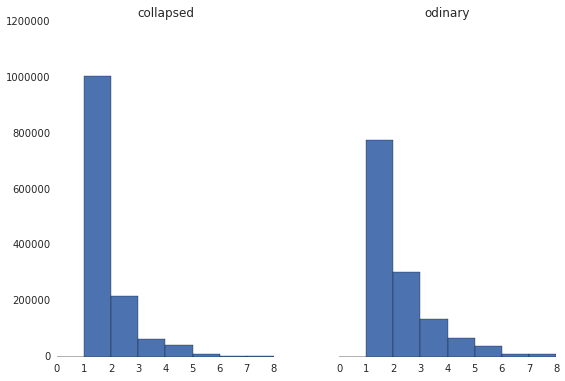

In [61]:
(
    results
    .applymap(len).hist(bins=range(0, 9), 
                        sharey=True, 
                        layout=(1, 3),
                        figsize=(14, 6))
)

In [64]:
# !rm -f ../data/geo-annotation/series.tissue.all.res1.pickle
(
    results
    [results.collapsed.map(len) == 1]
    .collapsed
    .map(lambda x: x[0])
    .rename(dict(collapsed='tissue'))
    .to_frame()
    .to_pickle('../data/geo-annotation/samples.tissue.cleaned.v1.pickle')
)

In [49]:
results.head()

,collapsed,odinary
item,,
E-MTAB-3099_162,[BTO:0000759],[BTO:0000759]
E-MEXP-1190_134,[BTO:0000759],[BTO:0000759]
E-MTAB-2146_16,"[BTO:0000886, BTO:0005257]","[BTO:0005257, BTO:0000886]"
E-MTAB-3732_3998,[BTO:0000876],"[BTO:0000876, BTO:0000089]"
E-TABM-1_5990,"[BTO:0000847, BTO:0000420, BTO:0000282]","[BTO:0001253, BTO:0000420, BTO:0000847, BTO:00..."


In [63]:
(
    results
#     .assign(collapsed_len=lambda d: d.collapsed.map(len))
#     .query('collapsed_len == 1')
    [results.collapsed.map(len) == 1]
#     .stored_samples
#     .sum()
    .shape
)

(1007873, 2)